In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Dataset paths
dataset_path = "/kaggle/input/intel-image-classification"
train_path = os.path.join(dataset_path, "seg_train/seg_train")
test_path = os.path.join(dataset_path, "seg_test/seg_test")

In [2]:
# Parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 10

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

In [26]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator.class_names

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


AttributeError: 'DirectoryIterator' object has no attribute 'class_names'

In [4]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False


model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation="softmax")
])


model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

base_model.trainable = True
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

fine_tune_epochs = 5
total_epochs = EPOCHS + fine_tune_epochs

history_fine_tune = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=EPOCHS,
    validation_data=test_generator
)


test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


439/439 ━━━━━━━━━━━━━━━━━━━━ 217s 459ms/step - accuracy: 0.2588 - loss: 1.7155 - val_accuracy: 0.4063 - val_loss: 1.3724
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 155s 348ms/step - accuracy: 0.3562 - loss: 1.4423 - val_accuracy: 0.4150 - val_loss: 1.3354
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 156s 349ms/step - accuracy: 0.3882 - loss: 1.4043 - val_accuracy: 0.4750 - val_loss: 1.2918
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 155s 349ms/step - accuracy: 0.3903 - loss: 1.3772 - val_accuracy: 0.4860 - val_loss: 1.2474
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 154s 346ms/step - accuracy: 0.4114 - loss: 1.3448 - val_accuracy: 0.5060 - val_loss: 1.1901
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 157s 351ms/step - accuracy: 0.4203 - loss: 1.3287 - val_accuracy: 0.5130 - val_loss: 1.1969
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 156s 350ms/step - accuracy: 0.4241 - loss: 1.3216 - val_accuracy: 0.5387 - val_loss: 1.1755
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 155s 347ms/step - accuracy: 0.4366 - loss: 1.30

In [5]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,235,156 (275.56 MB)

 Trainable params: 24,060,678 (91.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 48,121,358 (183.57 MB)

In [11]:
model.save('TransferLearningModel.h5')

In [15]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.9260 - loss: 0.2144
Test Accuracy: 92.33%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Class: SEA (4)
Confidence: 99.07%


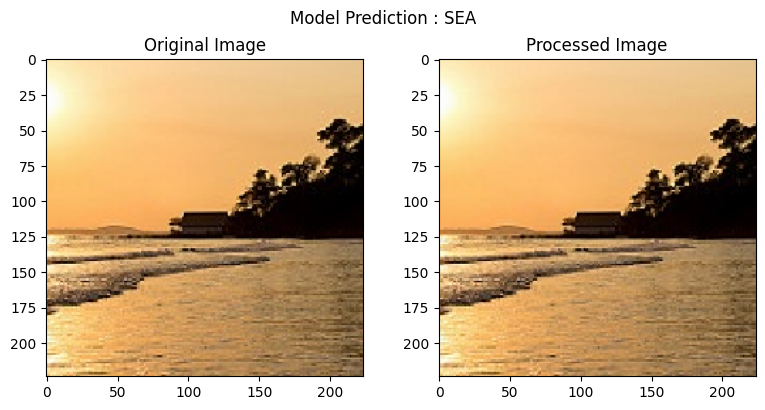

In [112]:

import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.image as mimg
import matplotlib.pyplot as plt
import random
from PIL import Image

# Path to the folder containing images
folder_path = "/kaggle/input/intel-image-classification/seg_pred/seg_pred"

# Get a list of all image file paths in the folder
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Choose a random image from the folder
random.seed(42)
random_image_path = random.choice(image_files)

def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)  # Load the image
    img_array = image.img_to_array(img)  
    img_array = img_array/255  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Preprocess the test image
test_image = preprocess_image(random_image_path)

# Predict the class of the image
predictions = model.predict(test_image)

# Get the predicted class index and probability
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class_probability = np.max(predictions)

# Map the class index to class name
class_indices = train_generator.class_indices

# Convert the class indices dictionary to a list of class names
class_names = list(class_indices.keys())
predicted_class_name = class_names[predicted_class_index]

def show_image(image_path, class_name=predicted_class_name, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)  # Load the image
    img_array = image.img_to_array(img)  
    img_array = img_array/255  # Normalize the image
    plt.figure(figsize=(8,4))
    plt.suptitle(f'Model Prediction : {class_name.upper()}')
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.title("Processed Image")
    plt.imshow(img_array)
    plt.tight_layout()

show_image(random_image_path)
# Output the results

print(f"Predicted Class: {predicted_class_name.upper()} ({predicted_class_index})")
print(f"Confidence: {predicted_class_probability * 100:.2f}%")


In [113]:
model.save("TLModel.h5")